The following Jupyter notebook is sourced here: https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f

In [400]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
# Some environment variable 'libiomp5md.dll' is causing kernel crashes, this is just to fix it for now.

import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

In [401]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = "~/datasets"
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

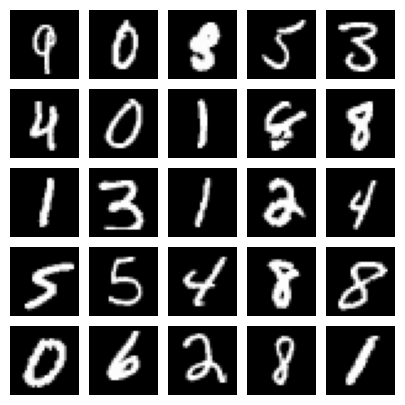

In [402]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i, 0] for i in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap="gray")
    ax.axis("off")

plt.show()

In [403]:
class Encoder(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=512, latent_dim=256):
        super(Encoder, self).__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear(hidden_dim, latent_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True

    def forward(self, x):
        x = self.LeakyReLU(self.linear1(x))
        x = self.LeakyReLU(self.linear2(x))

        mean = self.mean(x)
        log_var = self.var(x)
        return mean, log_var

In [404]:
class Decoder(nn.Module):

    def __init__(self, output_dim=784, hidden_dim=512, latent_dim=256):
        super(Decoder, self).__init__()

        self.linear2 = nn.Linear(latent_dim, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.LeakyReLU(self.linear2(x))
        x = self.LeakyReLU(self.linear1(x))

        x_hat = torch.sigmoid(self.output(x))
        return x_hat

In [405]:
class VAE(nn.Module):

    def __init__(
        self, input_dim=784, hidden1_dim=400, hidden2_dim=200, latent_dim=2, device=device
    ):
        super(VAE, self).__init__()

        self.input_dim = input_dim
        self.hidden1_dim = hidden1_dim
        self.hidden2_dim = hidden2_dim
        self.latent_dim = latent_dim
        self.device = device

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden1_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden1_dim, hidden2_dim),
            nn.LeakyReLU(0.2),
        ).to(device)

        # latent mean and Cholesky decomp of covariance
        self.mean_layer = nn.Linear(hidden2_dim, latent_dim, device=device)
        self.chol_layer = nn.Linear(
            hidden2_dim, (latent_dim * (latent_dim + 1)) // 2, device=device
        )

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden2_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden2_dim, hidden1_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden1_dim, input_dim),
            nn.Sigmoid(),
        ).to(device)

    def encode(self, x):
        x = self.encoder(x)
        mean, chol = self.mean_layer(x), self.chol_layer(x)
        return mean, chol

    def reparameterization(self, mean, chol):
        epsilon = torch.randn_like(mean, device=self.device)
        batch_size = mean.shape[0]
        L = torch.zeros(batch_size, self.latent_dim, self.latent_dim, device=self.device)
        tril_indices = torch.tril_indices(
            self.latent_dim, self.latent_dim, offset=0, device=self.device
        )
        L[:, tril_indices[0], tril_indices[1]] = chol
        z = mean + torch.einsum("bij,bj->bi", L, epsilon)
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, chol = self.encode(x)
        z = self.reparameterization(mean, chol)
        x_hat = self.decode(z)
        return x_hat, mean, chol

In [406]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [407]:
class UnFlatten(nn.Module):
    def forward(self, input, size=7*7*32):
        return input.view(input.size(0), size, 1, 1)

In [408]:
class CNN_VAE(nn.Module):

    def __init__(
        self, input_dim=784, latent_dim=2, device=device
    ):
        super(CNN_VAE, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.device = device

        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1), # 28 to 28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 28 to 14
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # 14 to 14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 14 to 7
        ).to(device)

        # latent mean and Cholesky decomp of covariance
        self.mean_layer = nn.Linear(7*7*32, latent_dim, device=device)
        self.chol_layer = nn.Linear(7*7*32, (latent_dim * (latent_dim + 1)) // 2, device=device)
        self.decode_layer = nn.Linear(latent_dim, 7*7*32)

        # decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # 7 to 14
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),   
            # nn.BatchNorm2d(8),
            # nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        ).to(device)
        
    def encode(self, x):
        x = self.encoder(x)
        # print(x.shape)
        x = x.view(x.size(0), -1) # Flattening...
        # print(x.shape)
        mean, chol = self.mean_layer(x), self.chol_layer(x)
        return mean, chol

    def reparameterization(self, mean, chol):
        epsilon = torch.randn_like(mean, device=self.device)
        batch_size = mean.shape[0]
        L = torch.zeros(batch_size, self.latent_dim, self.latent_dim, device=self.device)
        tril_indices = torch.tril_indices(
            self.latent_dim, self.latent_dim, offset=0, device=self.device
        )
        L[:, tril_indices[0], tril_indices[1]] = chol
        z = mean + torch.einsum("bij,bj->bi", L, epsilon)
        return z

    def decode(self, x):
        x = self.decode_layer(x)
        x = x.view(x.size(0), 32, 7, 7)
        return self.decoder(x)

    def forward(self, x):
        mean, chol = self.encode(x)
        z = self.reparameterization(mean, chol)
        x_hat = self.decode(z)
        return x_hat, mean, chol

The following is a modification of the VAE using a convolutional network. 
https://www.datacamp.com/tutorial/pytorch-cnn-tutorial
https://github.com/sksq96/pytorch-vae/blob/master/vae.py

In [409]:
model = CNN_VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

In [410]:
def loss_function(x, x_hat, mean, chol):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction="sum")

    batch_size = mean.shape[0]
    L = torch.zeros(batch_size, model.latent_dim, model.latent_dim, device=model.device)
    tril_indices = torch.tril_indices(
        model.latent_dim, model.latent_dim, offset=0, device=model.device
    )
    L[:, tril_indices[0], tril_indices[1]] = chol

    Sigma = torch.einsum("bij,bkj->bik", L, L)

    KLD = 0.5 * (
        torch.mean(torch.sum(mean.pow(2), axis=-1))
        + torch.mean(torch.sum(torch.diagonal(Sigma, offset=0, dim1=-2, dim2=-1), axis=-1))
        - torch.mean(torch.linalg.slogdet(Sigma).logabsdet)
        - model.latent_dim
    )

    return reproduction_loss + KLD

In [411]:
def train(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.to(device) # x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss / (batch_idx * batch_size))
    return overall_loss

In [412]:
train(model, optimizer, epochs=100, device=device)

	Epoch 1 	Average Loss:  211.85157032554258
	Epoch 2 	Average Loss:  173.58004675761686
	Epoch 3 	Average Loss:  167.2902762905624
	Epoch 4 	Average Loss:  164.3630829703151
	Epoch 5 	Average Loss:  162.7466950288241
	Epoch 6 	Average Loss:  160.67615351758138
	Epoch 7 	Average Loss:  159.82701215893678
	Epoch 8 	Average Loss:  158.06221086250522
	Epoch 9 	Average Loss:  157.09984790731949
	Epoch 10 	Average Loss:  156.17678358788083
	Epoch 11 	Average Loss:  156.36310780010956
	Epoch 12 	Average Loss:  159.26251568369156
	Epoch 13 	Average Loss:  155.73453204885746
	Epoch 14 	Average Loss:  154.68634605853507
	Epoch 15 	Average Loss:  154.12195739644199
	Epoch 16 	Average Loss:  153.54615893024834
	Epoch 17 	Average Loss:  154.02325074668718
	Epoch 18 	Average Loss:  152.96117273907032
	Epoch 19 	Average Loss:  152.53775786793094
	Epoch 20 	Average Loss:  153.0438416077577
	Epoch 21 	Average Loss:  152.10144487231324
	Epoch 22 	Average Loss:  151.6766921920649
	Epoch 23 	Average Loss:

8893853.041992188

In [413]:
def generate_digit(latent_vec):
    z_sample = torch.tensor([latent_vec], dtype=torch.float, device=model.device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28)  # reshape vector to 2d array
    plt.title(f"[{latent_vec[0]},{latent_vec[1]}]")
    plt.imshow(digit, cmap="gray")
    plt.axis("off")
    plt.show()

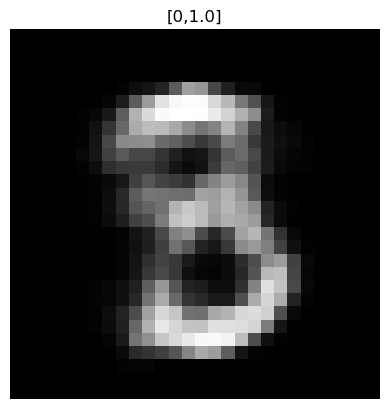

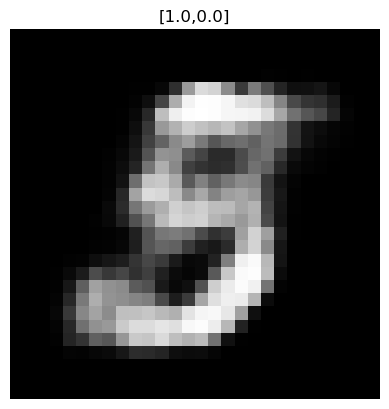

(None, None)

In [414]:
generate_digit([0, 1.0]), generate_digit([1.0, 0.0])

## Visualize the embedding of the training examples

In [415]:
from collections import defaultdict

encoded_reps = defaultdict(list)

for batch_idx, (x, labels) in enumerate(train_loader):
    x = x.view(batch_size, 784).to(device)
    mean_reps, chol_rep = model.encode(x)
    for rep, label in zip(mean_reps, labels):
        encoded_reps[int(label)].append(rep.detach().cpu().numpy())

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [100, 784]

In [ ]:
fig = plt.figure()
ax = fig.gca()
for label in range(10):
    ax.scatter(*zip(*encoded_reps[label]), s=1, label=str(label))

fig.legend()

## Visualize the generative model

In [416]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float, device=model.device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title("VAE Latent Space Visualization")
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z [0]")
    plt.ylabel("z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

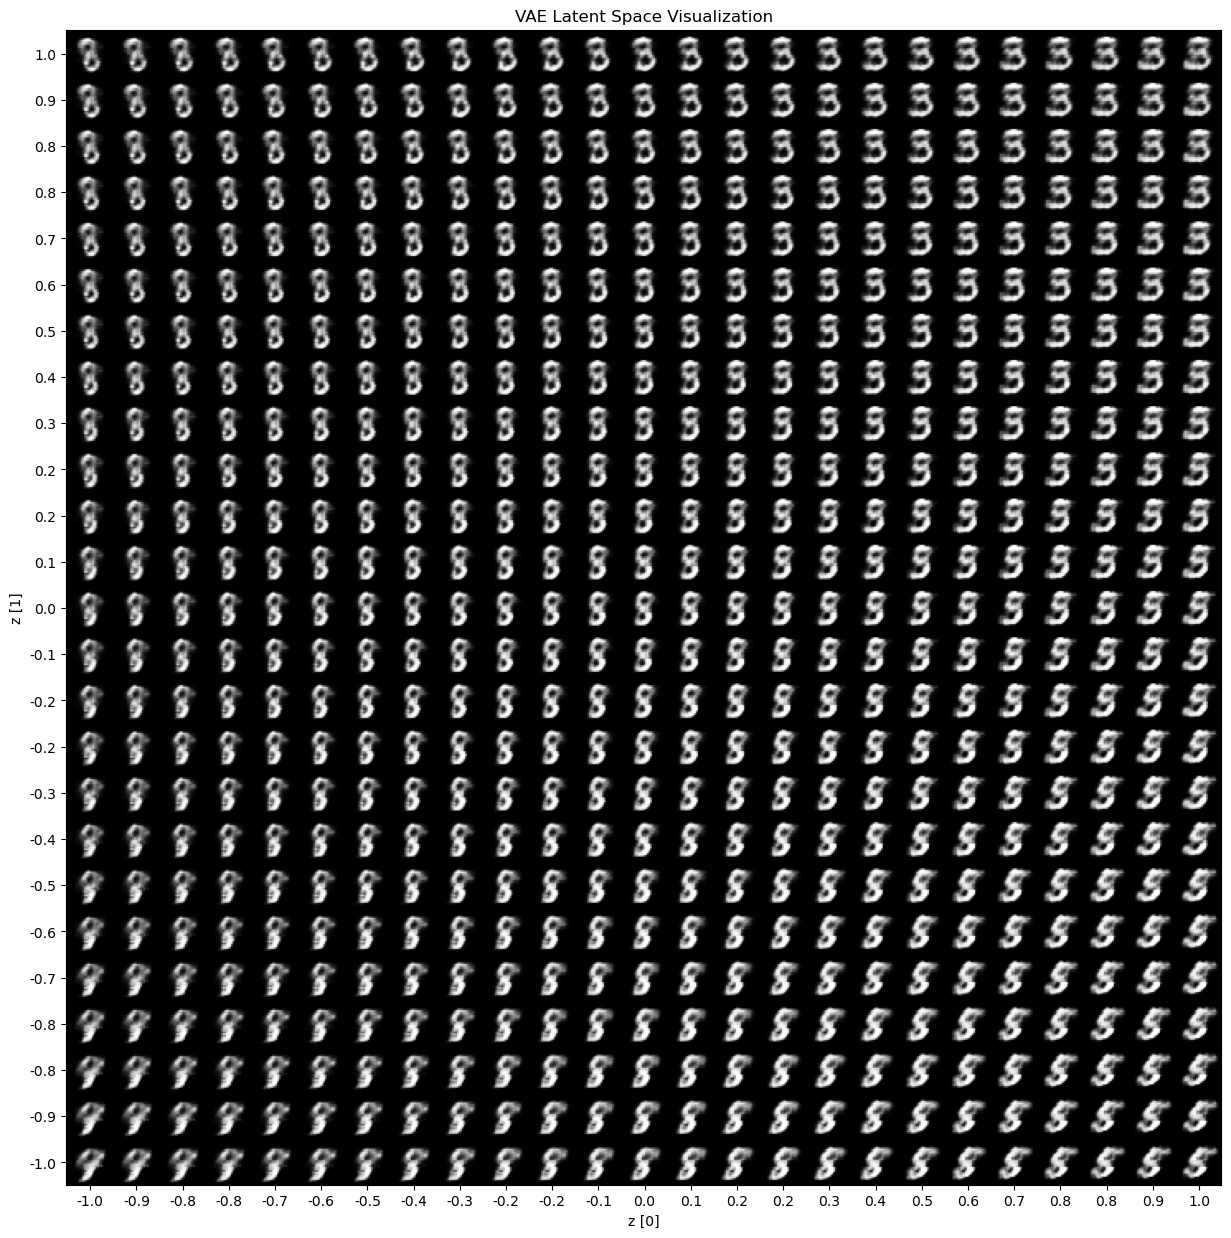

In [417]:
plot_latent_space(model, scale=1.0)

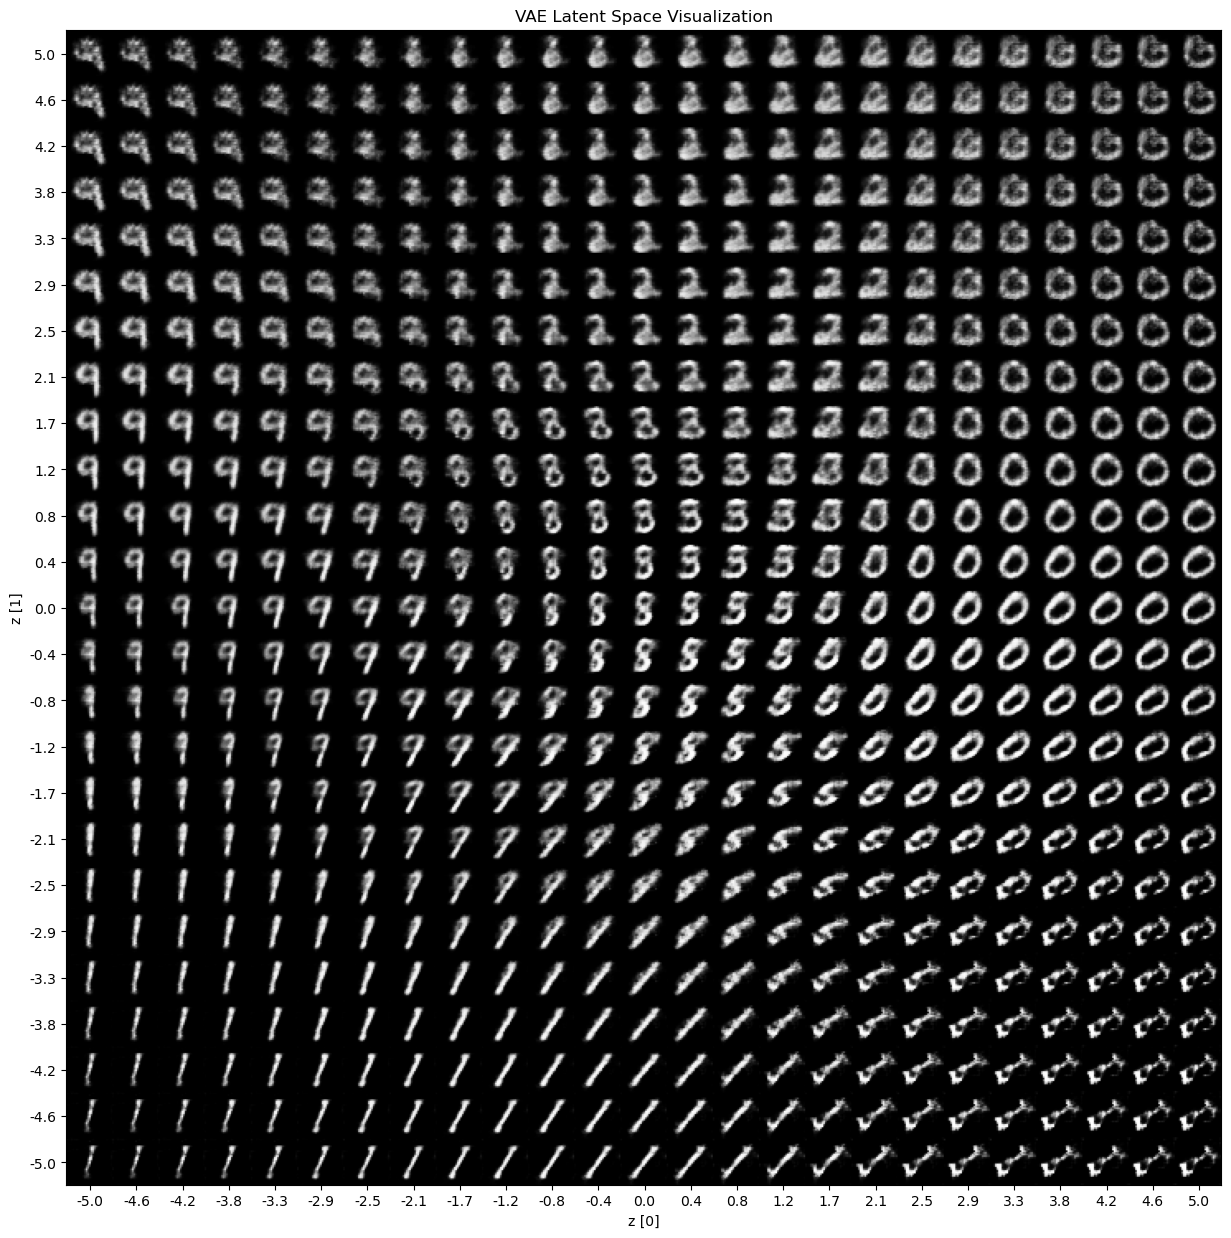

In [418]:
plot_latent_space(model, scale=5.0)